In [2]:
!pip install proglearn
!pip install git+https://github.com/neurodata/treeple.git

  Cloning https://github.com/neurodata/treeple.git to /tmp/pip-req-build-g0tfiuzn
  Running command git clone --filter=blob:none --quiet https://github.com/neurodata/treeple.git /tmp/pip-req-build-g0tfiuzn
  Resolved https://github.com/neurodata/treeple.git to commit 75c2cf919939574e4240fe261f053162039495cf
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for treeple: filename=treeple-0.10.3-cp311-cp311-linux_x86_64.whl size=2924554 sha256=5c87cfc384972afe51cf400461c2af0adee8b103c393a827b1fb892612d86848
  Stored in directory: /tmp/pip-ephem-wheel-cache-h6_qudr8/wheels/87/bd/56/9c9982c5af1eb667f0421e0000d3ed4b973b71c8e8903fa6cd
Successfully built treeple


In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from treeple import ObliqueRandomForestClassifier
from proglearn.sims import generate_gaussian_parity
from sklearn.metrics import accuracy_score
from proglearn.sims import generate_spirals
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist, fashion_mnist

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [29]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi / 4)

X_train_xor, X_test_xor, y_train_xor, y_test_xor = train_test_split(X_xor, y_xor, test_size=0.2,random_state=42)
X_train_rxor, X_test_rxor, y_train_rxor, y_test_rxor = train_test_split(X_rxor, y_rxor, test_size=0.2,random_state=42)

task_train_xor = np.zeros(len(y_train_xor), dtype=int)
task_train_rxor = np.ones(len(y_train_rxor), dtype=int)
task_test_xor = np.zeros(len(y_test_xor), dtype=int)
task_test_rxor = np.ones(len(y_test_rxor), dtype=int)

X_train_multi = np.column_stack((np.vstack([X_train_xor, X_train_rxor]), np.hstack([task_train_xor, task_train_rxor])))
y_train_multi = np.hstack([y_train_xor, y_train_rxor])

X_test_multi_xor = np.column_stack((X_test_xor, np.zeros(len(y_test_xor), dtype=int)))
X_test_multi_rxor = np.column_stack((X_test_rxor, np.ones(len(y_test_rxor), dtype=int)))


In [30]:
num_trials = 10
xor_accuracies = []
rxor_accuracies = []

for _ in range(num_trials):
    start_time = time.time()
    sporf_mtl = ObliqueRandomForestClassifier(n_estimators=100)
    sporf_mtl.fit(X_train_multi, y_train_multi)
    training_time = time.time() - start_time
    y_pred_xor = sporf_mtl.predict(X_test_multi_xor)
    y_pred_rxor = sporf_mtl.predict(X_test_multi_rxor)

    xor_accuracies.append(accuracy_score(y_test_xor, y_pred_xor))
    rxor_accuracies.append(accuracy_score(y_test_rxor, y_pred_rxor))


In [31]:
xor_accuracies = np.array(xor_accuracies)
rxor_accuracies = np.array(rxor_accuracies)
single_task_xor_accuracies = []
single_task_rxor_accuracies = []

for _ in range(num_trials):
    start_time = time.time()
    sporf_xor = ObliqueRandomForestClassifier(n_estimators=100)
    sporf_xor.fit(X_train_xor, y_train_xor)
    y_pred_xor = sporf_xor.predict(X_test_xor)
    single_task_xor_accuracies.append(accuracy_score(y_test_xor, y_pred_xor))

    start_time = time.time()
    sporf_rxor = ObliqueRandomForestClassifier(n_estimators=100)
    sporf_rxor.fit(X_train_rxor, y_train_rxor)
    y_pred_rxor = sporf_rxor.predict(X_test_rxor)
    single_task_rxor_accuracies.append(accuracy_score(y_test_rxor, y_pred_rxor))

single_task_xor_accuracies = np.array(single_task_xor_accuracies)
single_task_rxor_accuracies = np.array(single_task_rxor_accuracies)


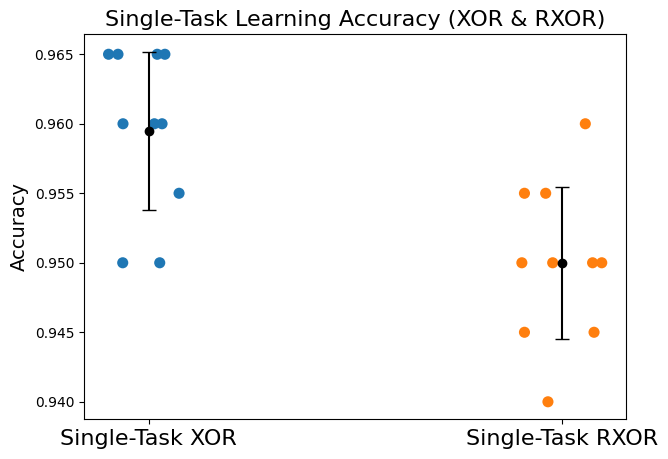

In [32]:
plt.figure(figsize=(7, 5))
sns.stripplot(data=[single_task_xor_accuracies, single_task_rxor_accuracies],
              jitter=True, size=8)

plt.errorbar([0, 1],
             [single_task_xor_accuracies.mean(), single_task_rxor_accuracies.mean()],
             yerr=[single_task_xor_accuracies.std(), single_task_rxor_accuracies.std()],
             fmt="o", color="black", capsize=5, zorder=3)

plt.xticks([0, 1], ["Single-Task XOR", "Single-Task RXOR"], fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Single-Task Learning Accuracy (XOR & RXOR)", fontsize=16)
plt.show()

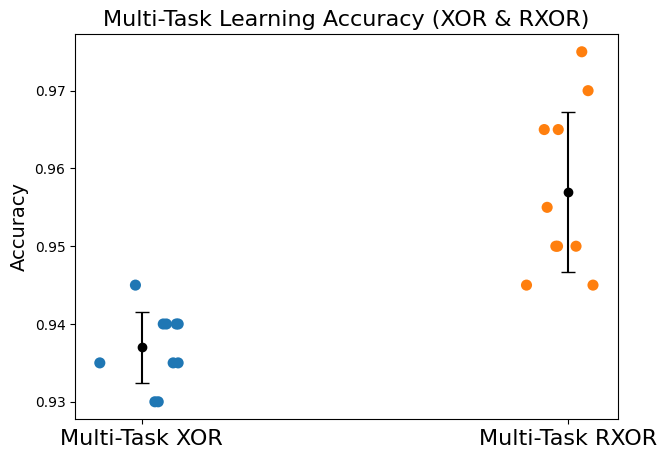

In [33]:
plt.figure(figsize=(7, 5))
sns.stripplot(data=[xor_accuracies, rxor_accuracies],
              jitter=True, size=8)

plt.errorbar([0, 1],
             [xor_accuracies.mean(), rxor_accuracies.mean()],
             yerr=[xor_accuracies.std(), rxor_accuracies.std()],
             fmt="o", color="black", capsize=5, zorder=3)

plt.xticks([0, 1], ["Multi-Task XOR", "Multi-Task RXOR"], fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Multi-Task Learning Accuracy (XOR & RXOR)", fontsize=16)
plt.show()

In [11]:
single_task_xor_mean = np.mean(single_task_xor_accuracies)
single_task_xor_std = np.std(single_task_xor_accuracies)
single_task_rxor_mean = np.mean(single_task_rxor_accuracies)
single_task_rxor_std = np.std(single_task_rxor_accuracies)
multi_task_xor_mean = np.mean(xor_accuracies)
multi_task_xor_std = np.std(xor_accuracies)
multi_task_rxor_mean = np.mean(rxor_accuracies)
multi_task_rxor_std = np.std(rxor_accuracies)

single_task_xor_time = training_time
single_task_rxor_time = training_time
multi_task_time = training_time

print(f"Single-Task XOR Accuracy: {single_task_xor_mean:.4f} ± {single_task_xor_std:.4f}")
print(f"Single-Task RXOR Accuracy: {single_task_rxor_mean:.4f} ± {single_task_rxor_std:.4f}")

print(f"Multi-Task XOR Accuracy: {multi_task_xor_mean:.4f} ± {multi_task_xor_std:.4f}")
print(f"Multi-Task RXOR Accuracy: {multi_task_rxor_mean:.4f} ± {multi_task_rxor_std:.4f}")

print(f"Single-Task XOR Training Time: {single_task_xor_time:.2f} sec")
print(f"Single-Task RXOR Training Time: {single_task_rxor_time:.2f} sec")

print(f"Total Multi-Task Training Time: {multi_task_time:.2f} sec")

Single-Task XOR Accuracy: 0.9117 ± 0.0042
Single-Task RXOR Accuracy: 0.9488 ± 0.0039
Multi-Task XOR Accuracy: 0.9136 ± 0.0052
Multi-Task RXOR Accuracy: 0.9466 ± 0.0068
Single-Task XOR Training Time: 0.21 sec
Single-Task RXOR Training Time: 0.21 sec
Total Multi-Task Training Time: 0.21 sec


##Hyperparamter Tunning for XOR/RXOR

In [54]:
results = []

for n_estimators in [100,200,500,1000,2000,5000]:
    for feature_combinations in [1.0, 1.5, 2.0, 3.0]:
        xor_accs, rxor_accs = [], []

        for _ in range(10):
            clf = ObliqueRandomForestClassifier(
                n_estimators=n_estimators,
                feature_combinations=feature_combinations,
                random_state=42
            )
            clf.fit(X_train_multi, y_train_multi)
            xor_preds = clf.predict(X_test_multi_xor)
            rxor_preds = clf.predict(X_test_multi_rxor)

            xor_accs.append(accuracy_score(y_test_xor, xor_preds))
            rxor_accs.append(accuracy_score(y_test_rxor, rxor_preds))

        results.append({
            "n_estimators": n_estimators,
            "feature_combinations": feature_combinations,
            "xor_acc": np.mean(xor_accs),
            "rxor_acc": np.mean(rxor_accs)
        })

results_df = pd.DataFrame(results)

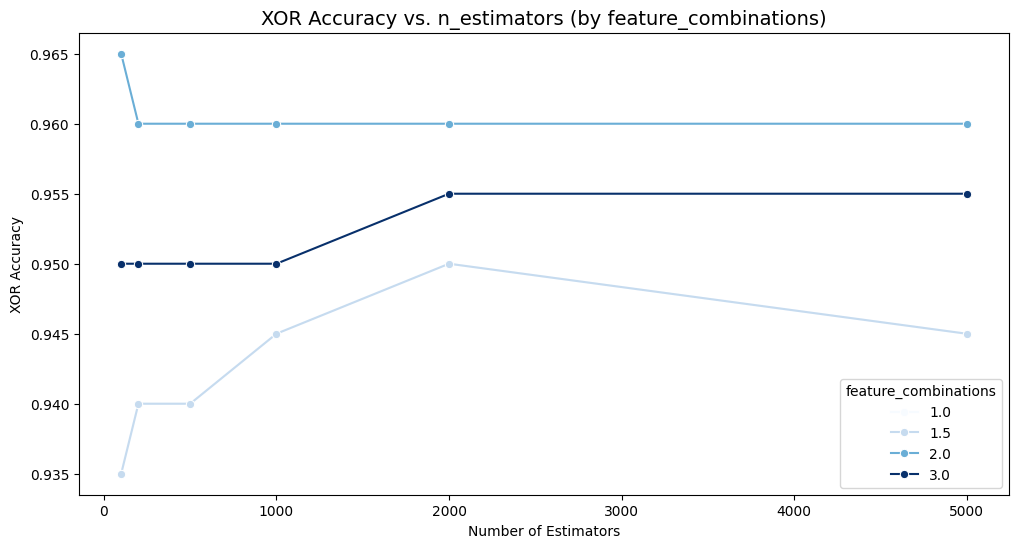

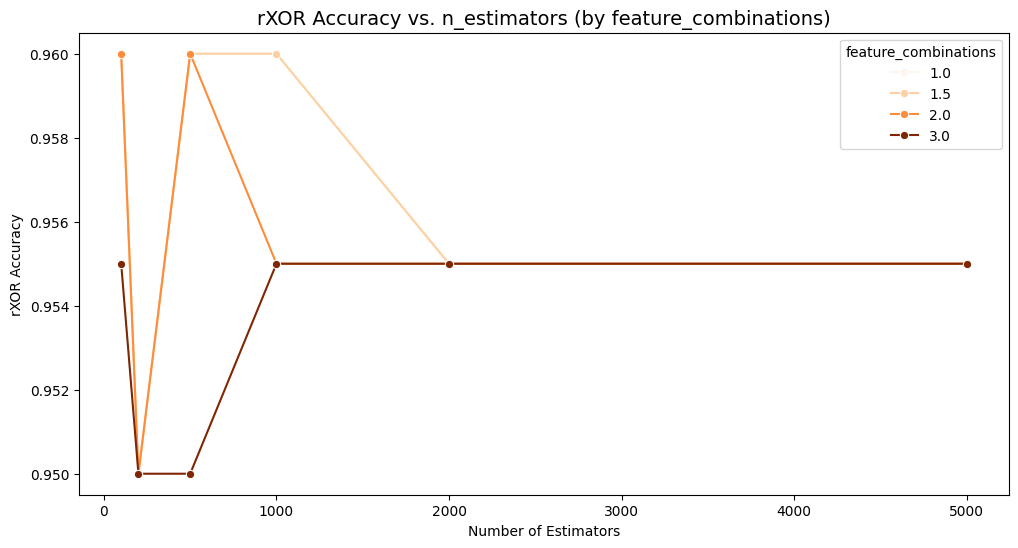

In [58]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x="n_estimators",
    y="xor_acc",
    hue="feature_combinations",
    marker="o",
    palette="Blues"
)
plt.title("XOR Accuracy vs. n_estimators (by feature_combinations)", fontsize=14)
plt.ylabel("XOR Accuracy")
plt.xlabel("Number of Estimators")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x="n_estimators",
    y="rxor_acc",
    hue="feature_combinations",
    marker="o",
    palette="Oranges"
)
plt.title("rXOR Accuracy vs. n_estimators (by feature_combinations)", fontsize=14)
plt.ylabel("rXOR Accuracy")
plt.xlabel("Number of Estimators")
plt.show()

In [61]:
results = []
for max_depth in [None, 5, 10, 20]:
    for min_samples_split in [2, 5]:
        for min_samples_leaf in [1, 5]:
            for bootstrap in [True, False]:
                xor_accs, rxor_accs = [], []

                for _ in range(10):
                    clf = ObliqueRandomForestClassifier(
                        n_estimators=200,
                        feature_combinations=2.0,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        bootstrap=bootstrap,
                        random_state=42
                    )
                    clf.fit(X_train_multi, y_train_multi)
                    xor_preds = clf.predict(X_test_multi_xor)
                    rxor_preds = clf.predict(X_test_multi_rxor)

                    xor_accs.append(accuracy_score(y_test_xor, xor_preds))
                    rxor_accs.append(accuracy_score(y_test_rxor, rxor_preds))

                results.append({
                    "max_depth": max_depth,
                    "min_samples_split": min_samples_split,
                    "min_samples_leaf": min_samples_leaf,
                    "bootstrap": bootstrap,
                    "xor_acc": np.mean(xor_accs),
                    "rxor_acc": np.mean(rxor_accs)
                })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
results_df

,max_depth,min_samples_split,min_samples_leaf,bootstrap,xor_acc,rxor_acc
0,NaN,2,1,True,0.960,0.950
1,NaN,2,1,False,0.955,0.945
2,NaN,2,5,True,0.945,0.965
3,NaN,2,5,False,0.945,0.965
4,NaN,5,1,True,0.955,0.960
5,NaN,5,1,False,0.960,0.965
6,NaN,5,5,True,0.945,0.965
7,NaN,5,5,False,0.945,0.965
8,5.0,2,1,True,0.935,0.965
9,5.0,2,1,False,0.920,0.970


#Spiral 3 vs Sprial 5


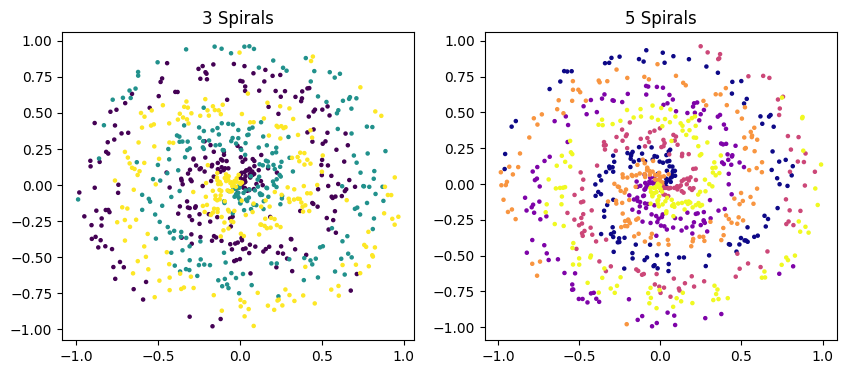

In [12]:
n_samples = 750
spiral3, y_spiral3 = generate_spirals(n_samples, 3, noise=0.8)
spiral5, y_spiral5 = generate_spirals(n_samples, 5, noise=0.4)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(spiral3[:, 0], spiral3[:, 1], c=y_spiral3, cmap="viridis", s=5)
plt.title("3 Spirals")

plt.subplot(1, 2, 2)
plt.scatter(spiral5[:, 0], spiral5[:, 1], c=y_spiral5, cmap="plasma", s=5)
plt.title("5 Spirals")

plt.show()

In [69]:
num_trials = 100

results = {
    "Spiral 3": {"accuracy": [], "time": []},
    "Spiral 5": {"accuracy": [], "time": []},
    "Multi-Task": {"accuracy": [], "time": []}
}

multi_task_spiral3_accuracies = []
multi_task_spiral5_accuracies = []

for _ in range(num_trials):
    spiral3, y_spiral3 = generate_spirals(750, 3, noise=0.8)
    spiral5, y_spiral5 = generate_spirals(750, 5, noise=0.4)

    X_train_spiral3, X_test_spiral3, y_train_spiral3, y_test_spiral3 = train_test_split(spiral3, y_spiral3, test_size=0.2)
    X_train_spiral5, X_test_spiral5, y_train_spiral5, y_test_spiral5 = train_test_split(spiral5, y_spiral5, test_size=0.2)

    scaler = StandardScaler()
    X_train_all = np.vstack([X_train_spiral3, X_train_spiral5])
    scaler.fit(X_train_all)

    X_train_spiral3 = scaler.transform(X_train_spiral3)
    X_train_spiral5 = scaler.transform(X_train_spiral5)
    X_test_spiral3 = scaler.transform(X_test_spiral3)
    X_test_spiral5 = scaler.transform(X_test_spiral5)

    start = time.time()
    sporf = ObliqueRandomForestClassifier(n_estimators=100)
    sporf.fit(X_train_spiral3, y_train_spiral3)
    y_pred = sporf.predict(X_test_spiral3)
    results["Spiral 3"]["accuracy"].append(accuracy_score(y_test_spiral3, y_pred))
    results["Spiral 3"]["time"].append(time.time() - start)

    start = time.time()
    sporf.fit(X_train_spiral5, y_train_spiral5)
    y_pred = sporf.predict(X_test_spiral5)
    results["Spiral 5"]["accuracy"].append(accuracy_score(y_test_spiral5, y_pred))
    results["Spiral 5"]["time"].append(time.time() - start)

    X_train_multi = np.vstack([X_train_spiral3, X_train_spiral5])
    y_train_multi = np.concatenate([y_train_spiral3, y_train_spiral5])
    task_labels_train = np.concatenate([np.zeros(len(y_train_spiral3)), np.ones(len(y_train_spiral5))])
    X_train_multi = np.column_stack((X_train_multi, task_labels_train))

    X_test_multi = np.vstack([X_test_spiral3, X_test_spiral5])
    y_test_multi = np.concatenate([y_test_spiral3, y_test_spiral5])
    task_labels_test = np.concatenate([np.zeros(len(y_test_spiral3)), np.ones(len(y_test_spiral5))])
    X_test_multi = np.column_stack((X_test_multi, task_labels_test))

    start = time.time()
    sporf.fit(X_train_multi, y_train_multi)
    y_pred_multi = sporf.predict(X_test_multi)
    results["Multi-Task"]["accuracy"].append(accuracy_score(y_test_multi, y_pred_multi))
    results["Multi-Task"]["time"].append(time.time() - start)

    X_test_spiral3_with_task = np.column_stack((X_test_spiral3, np.zeros(len(y_test_spiral3))))
    X_test_spiral5_with_task = np.column_stack((X_test_spiral5, np.ones(len(y_test_spiral5))))

    y_pred_spiral3 = sporf.predict(X_test_spiral3_with_task)
    y_pred_spiral5 = sporf.predict(X_test_spiral5_with_task)

    multi_task_spiral3_accuracies.append(accuracy_score(y_test_spiral3, y_pred_spiral3))
    multi_task_spiral5_accuracies.append(accuracy_score(y_test_spiral5, y_pred_spiral5))


In [92]:
results = []

for n_estimators in [100, 200, 500, 1000,2000,5000]:
    for feature_combinations in [1.5, 2.0]:
            clf = ObliqueRandomForestClassifier(
                n_estimators=n_estimators,
                feature_combinations=feature_combinations,
                max_depth=10,
                random_state=42
            )
            clf.fit(X_train_spiral3, y_train_spiral3)
            acc3_single = accuracy_score(y_test_spiral3, clf.predict(X_test_spiral3))

            clf.fit(X_train_spiral5, y_train_spiral5)
            acc5_single = accuracy_score(y_test_spiral5, clf.predict(X_test_spiral5))
            clf.fit(X_train_multi, y_train_multi)
            X_test3_multi = np.column_stack((X_test_spiral3, np.zeros(len(y_test_spiral3))))
            acc3_multi = accuracy_score(y_test_spiral3, clf.predict(X_test3_multi))
            X_test5_multi = np.column_stack((X_test_spiral5, np.ones(len(y_test_spiral5))))
            acc5_multi = accuracy_score(y_test_spiral5, clf.predict(X_test5_multi))

            results.append({
                "n_estimators": n_estimators,
                "feature_combinations": feature_combinations,
                "max_depth": max_depth,
                "spiral3_acc_single": acc3_single,
                "spiral5_acc_single": acc5_single,
                "spiral3_acc_multi": acc3_multi,
                "spiral5_acc_multi": acc5_multi
            })

spiral_results_df = pd.DataFrame(results)
spiral_results_df


,n_estimators,feature_combinations,max_depth,spiral3_acc_single,spiral5_acc_single,spiral3_acc_multi,spiral5_acc_multi
0,100,1.5,10,0.646667,0.640000,0.566667,0.493333
1,100,2.0,10,0.713333,0.680000,0.680000,0.706667
2,200,1.5,10,0.640000,0.660000,0.566667,0.493333
3,200,2.0,10,0.706667,0.680000,0.680000,0.700000
4,500,1.5,10,0.620000,0.660000,0.580000,0.486667
5,500,2.0,10,0.700000,0.660000,0.700000,0.693333
6,1000,1.5,10,0.620000,0.666667,0.573333,0.466667
7,1000,2.0,10,0.706667,0.673333,0.686667,0.706667
8,2000,1.5,10,0.613333,0.646667,0.573333,0.473333
9,2000,2.0,10,0.713333,0.673333,0.673333,0.693333


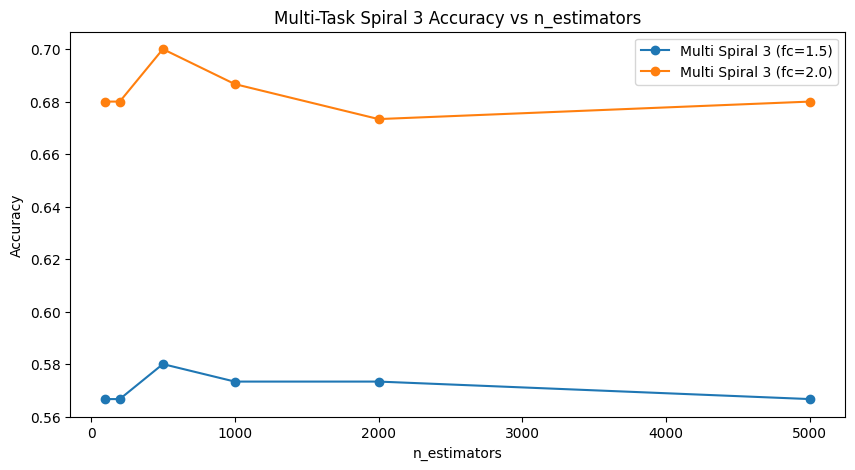

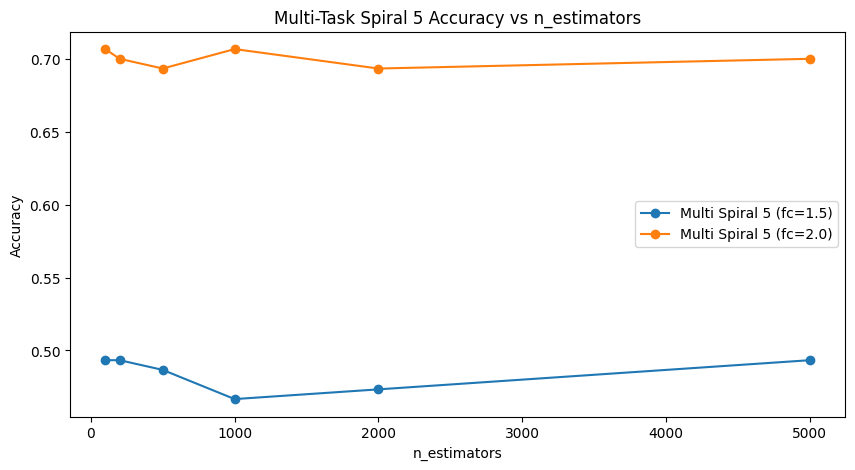

In [98]:
plt.figure(figsize=(10, 5))
for fc in [1.5, 2.0]:
    subset = spiral_results_df[spiral_results_df["feature_combinations"] == fc]
    plt.plot(
        subset["n_estimators"],
        subset["spiral3_acc_multi"],
        marker='o',
        label=f'Multi Spiral 3 (fc={fc})'
    )

plt.title("Multi-Task Spiral 3 Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for fc in [1.5, 2.0]:
    subset = spiral_results_df[spiral_results_df["feature_combinations"] == fc]
    plt.plot(
        subset["n_estimators"],
        subset["spiral5_acc_multi"],
        marker='o',
        label=f'Multi Spiral 5 (fc={fc})'
    )

plt.title("Multi-Task Spiral 5 Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [99]:
results = []

for max_depth in [None, 5, 10, 20]:
    for min_samples_split in [2, 5]:
        for min_samples_leaf in [1, 5]:
            for bootstrap in [True, False]:
                spiral3_accs, spiral5_accs = [], []

                for _ in range(10):
                    clf = ObliqueRandomForestClassifier(
                        n_estimators=200,
                        feature_combinations=2.0,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        bootstrap=bootstrap,
                        random_state=42
                    )
                    clf.fit(X_train_multi, y_train_multi)

                    # Spiral 3 prediction (task label = 0)
                    X_test3_multi = np.column_stack((X_test_spiral3, np.zeros(len(y_test_spiral3))))
                    preds_3 = clf.predict(X_test3_multi)
                    spiral3_accs.append(accuracy_score(y_test_spiral3, preds_3))

                    # Spiral 5 prediction (task label = 1)
                    X_test5_multi = np.column_stack((X_test_spiral5, np.ones(len(y_test_spiral5))))
                    preds_5 = clf.predict(X_test5_multi)
                    spiral5_accs.append(accuracy_score(y_test_spiral5, preds_5))

                results.append({
                    "max_depth": max_depth,
                    "min_samples_split": min_samples_split,
                    "min_samples_leaf": min_samples_leaf,
                    "bootstrap": bootstrap,
                    "spiral3_acc": np.mean(spiral3_accs),
                    "spiral5_acc": np.mean(spiral5_accs)
                })

# Convert to DataFrame
spiral_tuning_df = pd.DataFrame(results)
spiral_tuning_df


,max_depth,min_samples_split,min_samples_leaf,bootstrap,spiral3_acc,spiral5_acc
0,NaN,2,1,True,0.713333,0.733333
1,NaN,2,1,False,0.640000,0.726667
2,NaN,2,5,True,0.733333,0.686667
3,NaN,2,5,False,0.706667,0.693333
4,NaN,5,1,True,0.720000,0.713333
5,NaN,5,1,False,0.666667,0.706667
6,NaN,5,5,True,0.733333,0.686667
7,NaN,5,5,False,0.706667,0.693333
8,5.0,2,1,True,0.600000,0.433333
9,5.0,2,1,False,0.526667,0.440000


from matplotlib import pyplot as plt
_df_15['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['max_depth'].plot(kind='hist', bins=20, title='max_depth')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['min_samples_split'].plot(kind='hist', bins=20, title='min_samples_split')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['min_samples_leaf'].plot(kind='hist', bins=20, title='min_samples_leaf')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_19.groupby('bootstrap').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='index', y='max_depth', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='max_depth', y='min_samples_split', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='min_samples_split', y='min_samples_leaf', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='min_samples_leaf', y='spiral3_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['max_depth']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('bootstrap')):
  _plot_series(series, series_name, i)
  fig.legend(title='bootstrap', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('max_depth')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['min_samples_split']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('bootstrap')):
  _plot_series(series, series_name, i)
  fig.legend(title='bootstrap', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('min_samples_split')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['min_samples_leaf']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('bootstrap')):
  _plot_series(series, series_name, i)
  fig.legend(title='bootstrap', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('min_samples_leaf')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['spiral3_acc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('bootstrap')):
  _plot_series(series, series_name, i)
  fig.legend(title='bootstrap', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('spiral3_acc')

from matplotlib import pyplot as plt
_df_28['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['max_depth'].plot(kind='line', figsize=(8, 4), title='max_depth')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['min_samples_split'].plot(kind='line', figsize=(8, 4), title='min_samples_split')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['min_samples_leaf'].plot(kind='line', figsize=(8, 4), title='min_samples_leaf')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_32['bootstrap'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_32, x='index', y='bootstrap', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_33['bootstrap'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_33, x='max_depth', y='bootstrap', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_34['bootstrap'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_34, x='min_samples_split', y='bootstrap', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_35['bootstrap'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_35, x='min_samples_leaf', y='bootstrap', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

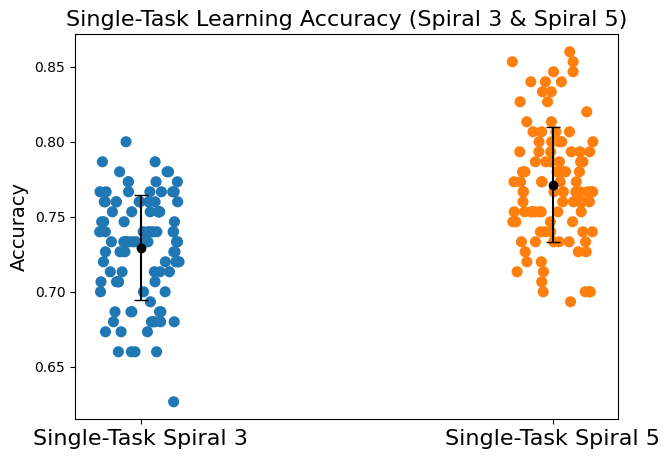

In [14]:
for key in results:
    results[key]["accuracy"] = np.array(results[key]["accuracy"])
    results[key]["time"] = np.array(results[key]["time"])

plt.figure(figsize=(7, 5))
sns.stripplot(data=[results["Spiral 3"]["accuracy"], results["Spiral 5"]["accuracy"]],
              jitter=True, size=8)

plt.errorbar([0, 1], [results["Spiral 3"]["accuracy"].mean(), results["Spiral 5"]["accuracy"].mean()],
                 yerr=[results["Spiral 3"]["accuracy"].std(), results["Spiral 5"]["accuracy"].std()],
                 fmt="o", color="black", capsize=5, zorder=3)

plt.xticks([0, 1], ["Single-Task Spiral 3", "Single-Task Spiral 5"], fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Single-Task Learning Accuracy (Spiral 3 & Spiral 5)", fontsize=16)
plt.show()

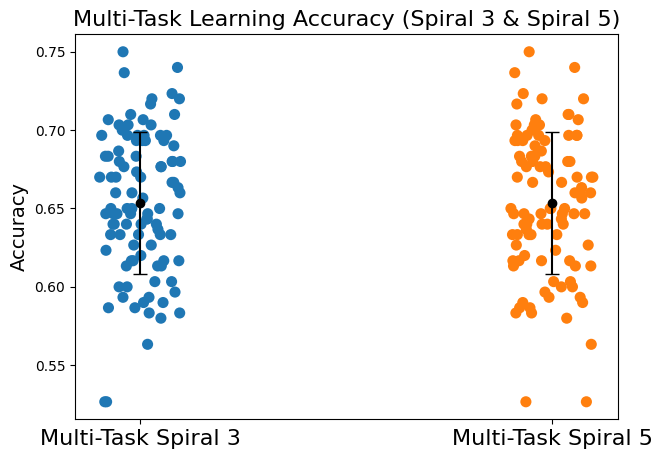

In [15]:
plt.figure(figsize=(7, 5))
sns.stripplot(data=[results["Multi-Task"]["accuracy"], results["Multi-Task"]["accuracy"]],
              jitter=True, size=8)

plt.errorbar([0, 1], [results["Multi-Task"]["accuracy"].mean(), results["Multi-Task"]["accuracy"].mean()],
             yerr=[results["Multi-Task"]["accuracy"].std(), results["Multi-Task"]["accuracy"].std()],
             fmt="o", color="black", capsize=5, zorder=3)

plt.xticks([0, 1], ["Multi-Task Spiral 3", "Multi-Task Spiral 5"], fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Multi-Task Learning Accuracy (Spiral 3 & Spiral 5)", fontsize=16)
plt.show()


In [16]:
spiral3_mean = np.mean(results["Spiral 3"]["accuracy"])
spiral3_std = np.std(results["Spiral 3"]["accuracy"])
spiral5_mean = np.mean(results["Spiral 5"]["accuracy"])
spiral5_std = np.std(results["Spiral 5"]["accuracy"])

multi_task_spiral3_mean = np.mean(multi_task_spiral3_accuracies)
multi_task_spiral3_std = np.std(multi_task_spiral3_accuracies)
multi_task_spiral5_mean = np.mean(multi_task_spiral5_accuracies)
multi_task_spiral5_std = np.std(multi_task_spiral5_accuracies)

spiral3_time_mean = np.mean(results["Spiral 3"]["time"])
spiral3_time_std = np.std(results["Spiral 3"]["time"])
spiral5_time_mean = np.mean(results["Spiral 5"]["time"])
spiral5_time_std = np.std(results["Spiral 5"]["time"])
multi_task_time_mean = np.mean(results["Multi-Task"]["time"])
multi_task_time_std = np.std(results["Multi-Task"]["time"])


print(f"Spiral 3 Accuracy: {spiral3_mean:.4f} ± {spiral3_std:.4f}")
print(f"Spiral 3 Training Time: {spiral3_time_mean:.2f} sec ± {spiral3_time_std:.2f} sec")

print(f"Spiral 5 Accuracy: {spiral5_mean:.4f} ± {spiral5_std:.4f}")
print(f"Spiral 5 Training Time: {spiral5_time_mean:.2f} sec ± {spiral5_time_std:.2f} sec")

print(f"Multi-Task Spiral 3 Accuracy: {multi_task_spiral3_mean:.4f} ± {multi_task_spiral3_std:.4f}")
print(f"Multi-Task Spiral 5 Accuracy: {multi_task_spiral5_mean:.4f} ± {multi_task_spiral5_std:.4f}")

print(f"Total Multi-Task Training Time: {multi_task_time_mean:.2f} sec ± {multi_task_time_std:.2f} sec")


Spiral 3 Accuracy: 0.7293 ± 0.0350
Spiral 3 Training Time: 0.26 sec ± 0.05 sec
Spiral 5 Accuracy: 0.7715 ± 0.0386
Spiral 5 Training Time: 0.27 sec ± 0.05 sec
Multi-Task Spiral 3 Accuracy: 0.6505 ± 0.0550
Multi-Task Spiral 5 Accuracy: 0.6564 ± 0.0605
Total Multi-Task Training Time: 0.25 sec ± 0.05 sec
